# Load Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from scipy.optimize import curve_fit,minimize
from glob import glob
from scipy.interpolate import InterpolatedUnivariateSpline
import re
import os

In [2]:
doorbbary=True
dolocalbary=True
if doorbbary:
    SOURCENAME='herx1' # For GBM PSR data 
else:
    NU=0.807 # guess for PSR frequency
    NUDOT=0
OBSID='02003801'
MODF='FTP/caldb/data/ixpe/gpd/cpf/modfact/ixpe_d%d_20170101_mfact_02.fits'

# Setup  Directories

In [3]:
os.system('[ -d output ] || mkdir output ; [ -d figures ] || mkdir figures ; [ -d data ] || mkdir data')

0

# Setup Data and Modulation Files in Data Directory

In [4]:
DIRECTORY='FTP/ixpe/data/obs/%s//%s/' % (OBSID[0:2],OBSID)
SCIHEADER='/home/idies/workspace/headata'

## Set up Raw Data Files

In [5]:
rawdatafilelist=sorted(glob('data/ixpe*_det?_evt2_*.fits*'))
if len(rawdatafilelist)<3:
    print('get data files')
    # if you are on sciserver create symbolic links to the data, otherwise download the manifest and then files
    if os.path.isdir('%s/%s/event_l2/' % (SCIHEADER,DIRECTORY)):
        os.system('cd data ; for ii in %s/%s/event_l2/*.fits.gz ; do ln -s $ii ; done' % (SCIHEADER,DIRECTORY))
    else:
        os.system('cd data ; wget -nH -nv --cut-dirs=8 https://heasarc.gsfc.nasa.gov/%s/event_l2/' % DIRECTORY)
        with open('data/index.html','r') as f:
            for line in f:
                res=re.search('href="ixpe.+fits\.gz"',line)
                if res is not None:
                    os.system('cd data  ; wget -nH -nv --cut-dirs=8 https://heasarc.gsfc.nasa.gov/%s/event_l2/%s' % (DIRECTORY,line[res.start()+6:res.end()-1]))
        os.remove('data/index.html')
    rawdatafilelist=sorted(glob('data/ixpe*_det?_evt2_*.fits*'))

## Perform Spacecraft barycentering

In [6]:
if dolocalbary:
    orbfilelist=sorted(glob('data/ixpe*orb_*fits*'))
    if len(orbfilelist)<1:
        print('get orb files')
        # if you are on sciserver create symbolic links to the data, otherwise download the manifest and then files
        if os.path.isdir('%s/%s/hk/' % (SCIHEADER,DIRECTORY)):
            os.system('cd data ; for ii in %s/%s/hk/*orb*.fits.gz ; do ln -s $ii ; done' % (SCIHEADER,DIRECTORY))
        else:
            os.system('cd data ; wget -nH -nv --cut-dirs=8 https://heasarc.gsfc.nasa.gov/%s/hk/' % DIRECTORY)
            with open('data/index.html','r') as f:
                for line in f:
                    res=re.search('href="ixpe.+orb.+fits\.gz"',line)
                    if res is not None:
                        os.system('cd data  ; wget -nH -nv --cut-dirs=8 https://heasarc.gsfc.nasa.gov/%s/hk/%s' % (DIRECTORY,line[res.start()+6:res.end()-1]))
            os.remove('data/index.html')
    orbfilelist=sorted(glob('data/ixpe*orb_*fits*'))
    datafilelist=sorted(glob('data/ixpe*_det?_evt2_*_bary.fits*'))
    if len(datafilelist)<3:
        print('perform barycentric correction')
        for ff in rawdatafilelist:
            os.system('HEADASNOQUERY= HEADASPROMPT=/dev/null barycorr %s %s %s' % (ff,ff.replace('.fits.gz','_bary.fits.gz'),','.join(orbfilelist)))
    datafilelist=sorted(glob('data/ixpe*_det?_evt2_*_bary.fits*'))
else:
    datafilelist=rawdatafilelist
#/home/idies/workspace/headata/FTP/caldb/data
#https://heasarc.gsfc.nasa.gov/FTP/ixpe/data/obs/01//01001899/event_l2/ixpe01001899_det1_evt2_v02.fits.gz
#https://heasarc.gsfc.nasa.gov/FTP/ixpe/data/obs/01//01001899/hk/
#https://heasarc.gsfc.nasa.gov/FTP/ixpe/data/obs/02//02003801/event_l2/

## Setup modulation files

In [7]:
modfilelist=sorted(glob('data/ixpe*_mfact*.fits*'))
if len(modfilelist)<3:
    print('get modf files')
    # if you are on sciserver create symbolic links to the data, otherwise download the manifest and then files
    if os.path.exists('%s/%s' % (SCIHEADER,MODF.replace('%d','1'))):
        os.system('cd data ; for ii in %s/%s ; do ln -s $ii ; done' % (SCIHEADER,MODF.replace('%d','?')))
    else:
        for i in range(1,4):
            os.system((('cd data ; wget -nH -nv --cut-dirs=8 https://heasarc.gsfc.nasa.gov/%s' % MODF)) % i)
    modfilelist=sorted(glob('data/ixpe*_mfact*.fits*'))


# Definition of RVM

In [8]:
def angfunk(alpha,beta,phase):
    tanhalfC=np.tan(phase*np.pi)
    halfamb=np.radians(alpha-beta)/2
    halfapb=np.radians(alpha+beta)/2
    halfAmB=np.arctan2(np.sin(halfamb),np.sin(halfapb)*tanhalfC)
    halfApB=np.arctan2(np.cos(halfamb),np.cos(halfapb)*tanhalfC)
    return (halfAmB-halfApB)


# Load Data and Modulation Fraction

In [9]:
IXPEOBSSIM_DIR='/home/idies/workspace/Storage/dgonzalez/persistent/ixpesw-ixpeobssim-8253fe2836b8_v23_3_0'
nphotondu=np.zeros(4).astype(int)
#for i,f in enumerate(sorted(glob('01003299/event_l2/ixpe01003299_det?_evt2_v02_geocenter.fits.gz'))):
for i,f in enumerate(datafilelist): 
    print(i,f)
    with fits.open(modfilelist[i]) as hdu:
        modlist=hdu[1].data['SPECRESP']
    with fits.open(f) as hdu:
        # hdu[1].data['PI']=pislope[i]*hdu[1].data['PI']+pioffset[i]
        if (i==0):
            MJDREFI=hdu[0].header['MJDREFI']
            MJDREFF=hdu[0].header['MJDREFF']
            LIVETIME=hdu[0].header['LIVETIME']
            evtlist=hdu[1].data
            moddata=np.transpose(modlist[np.clip(hdu[1].data['PI']-25,0,len(modlist)-1)])
            detector=np.full(len(hdu[1].data),i+1)
        else:
            evtlist=np.append(evtlist,hdu[1].data)
            moddata=np.concatenate((moddata,np.transpose(modlist[np.clip(hdu[1].data['PI']-25,0,len(modlist)-1)])))
            detector=np.concatenate((detector,np.full(len(hdu[1].data),i+1)))


0 data/ixpe02003801_det1_evt2_v01_bary.fits.gz
1 data/ixpe02003801_det2_evt2_v01_bary.fits.gz
2 data/ixpe02003801_det3_evt2_v01_bary.fits.gz


In [10]:
xc, yc=300, 300
for _i in range(5):
    rr=np.hypot(evtlist['X']-xc,evtlist['Y']-yc)
    ok=(evtlist['PI']>49) & (evtlist['PI']<=200) & (rr<50) 
    xc,yc=np.mean(evtlist['X'][ok]),np.mean(evtlist['Y'][ok])
    print(xc,yc)
rr=np.hypot(evtlist['X']-xc,evtlist['Y']-yc)
ok=(evtlist['PI']>49) & (evtlist['PI']<=200) & (rr<20) 
back=(evtlist['PI']>49) & (evtlist['PI']<=200) & (rr>30)  & (rr<50)
evtback=evtlist[back]
evtlist=evtlist[ok]
modback=moddata[back]
moddata=moddata[ok]
detback=detector[back]
detector=detector[ok]


304.53488 288.8549
304.85223 288.09387
304.87573 288.04214
304.87708 288.03912
304.87717 288.0387


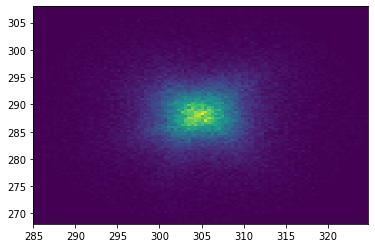

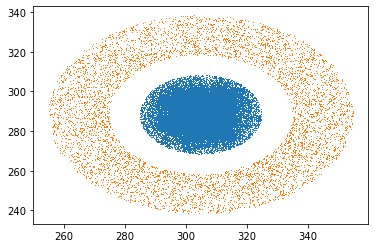

In [11]:
plt.hist2d(evtlist['X'],evtlist['Y'],bins=100)
plt.show()
plt.plot(evtlist['X'],evtlist['Y'],',')
plt.plot(evtback['X'],evtback['Y'],',')

In [12]:
len(evtback)/len(evtlist)/4

0.015027038783600755

In [13]:
pispec=np.histogram(evtlist['PI'],bins=150)[0]
np.save('output/pispec',pispec)

In [14]:
backpispec=np.histogram(evtback['PI'],bins=150)[0]*20**2/(50**2-30**2)
np.save('output/backpispec',backpispec)

In [15]:
for i in range(1,4):
    _q,_u=np.mean((evtlist['Q']/moddata)[detector==i]),np.mean((evtlist['U']/moddata)[detector==i])
    print(i,_q,_u,np.hypot(_q,_u))

1 0.014527487407638212 0.13963086134817693 0.14038456229661755
2 0.013509174422861992 0.16497249227866365 0.16552468396653428
3 0.004564333980390779 0.16889301792035916 0.16895468222849377


# Barycentring First Try with GBM Orbital Elements

In [16]:

if doorbbary:
    os.system('[ -f %s.fits.gz ] || curl https://gammaray.nsstc.nasa.gov/gbm/science/pulsars/lightcurves/%s.fits.gz --output %s.fits.gz' % (SOURCENAME,SOURCENAME,SOURCENAME))
    with fits.open('%s.fits.gz' % SOURCENAME)  as hdu:
        orbitdata=hdu['Orbital Elements'].data
        spindata=hdu['PSR_HIST'].data
    day=3600*24
    TPIOVER2O=orbitdata['BINARYEPOCH']-2400000.5
    PORB=orbitdata['PBINARY']*day
    PORBDOT=orbitdata['PBDOT']
    ECCENTRICITY=orbitdata['ECCENTRICITY']
    OMEGA=orbitdata['PERIAPSE']
    ASINIOVERC=orbitdata['AXSINI']
    NUORB=1/PORB
    NUORBDOT=-1/PORB/PORB*PORBDOT
    met0=evtlist['TIME'].min()
    MJDSTART=MJDREFF+MJDREFI+met0/day
    NU=np.interp(MJDSTART,spindata['BARYTIME'],spindata['FREQUENCY'])
    NUDOT=np.interp(MJDSTART,spindata['BARYTIME'],spindata['FDOT'])
    TREFNU=MJDSTART
    torb=((MJDREFF+MJDREFI)+evtlist['TIME']/day-TPIOVER2O)*day
    phaseorb=(0.25+torb*(NUORB+torb*NUORBDOT/2))                    
    orbtime=ASINIOVERC*((np.sin(2*np.pi*phaseorb)-np.sin(np.pi/2))-
                    0.5*ECCENTRICITY*(np.sin(4*np.pi*phaseorb-np.radians(OMEGA))-
                                      np.sin(np.pi/2-np.radians(OMEGA))))
    deltat=evtlist['TIME']-orbtime-met0
    freqtst=NU
    if NUDOT==0:
        _ii=spindata['BARYTIME']>59000
        nufunk=InterpolatedUnivariateSpline(spindata['BARYTIME'][_ii],spindata['FREQUENCY'][_ii],k=2)
        nudd=nufunk.derivatives(MJDSTART)
        NU=nudd[0]
        NUDOT=nudd[1]/day
        NUDDOT=nudd[2]/day/day
    else:
        NUDDOT=0

else:
    deltat=evtlist['TIME']-evtlist['TIME'].min()
phdata=np.mod(deltat*(NU+0*0.5*deltat*(NUDOT*deltat*NUDDOT*0.3333333)),1)

In [17]:
MJDSTART,NU,NUDOT,freqtst,LIVETIME

(59962.736016378476,
 0.8079471829349216,
 4.016178051982288e-13,
 0.8079470061742823,
 148272.52476)

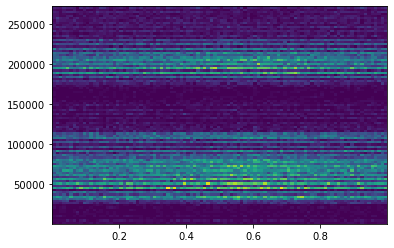

In [18]:
bindata=plt.hist2d(phdata,deltat,bins=100)

In [19]:
phdata=np.mod(deltat*(NU+1e-6)+0.03,1)

In [20]:
NU,deltat.min()

(0.8079471829349216, 2.638435333967209)

0.17224409448818898


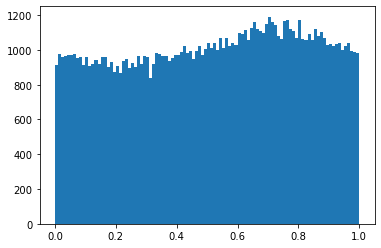

In [21]:
toton=plt.hist(phdata,bins=100)
print((toton[0].max()-toton[0].min())/(toton[0].max()+toton[0].min()))

In [22]:
np.argmax(toton[0])

70

In [23]:
np.savez('output/toton',toton,dtype=object)

/home/idies/miniconda3/envs/heasoft/lib/python3.8/site-packages/numpy/lib/npyio.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


# Unbinned Likelihood Analysis

In [24]:
qdata=evtlist['Q']*moddata
udata=evtlist['U']*moddata

def maxlikephase(param):
    for _i in range(len(param)//2):
        qloc[_i]=np.cos(2*param[2*_i])*np.tanh(param[2*_i+1])
        uloc[_i]=np.sin(2*param[2*_i])*np.tanh(param[2*_i+1])
#        qloc[_i]=param[2*_i]
#        uloc[_i]=param[2*_i+1]

    return(-np.sum(np.log(1+0.5*(qloc[phbin]*qdata+uloc[phbin]*udata))))

def maxlikephaseok(param,_phb,_qd,_ud):
    for _i in range(len(param)//2):
        qloc[_i]=np.cos(2*param[2*_i])*np.tanh(param[2*_i+1])
        uloc[_i]=np.sin(2*param[2*_i])*np.tanh(param[2*_i+1])
#        qloc[_i]=param[2*_i]
#        uloc[_i]=param[2*_i+1]

    return(-np.sum(np.log(1+0.5*(qloc[_phb]*_qd+uloc[_phb]*_ud))))


def maxlikephasequ(param):
    for _i in range(len(param)//2):
        qloc[_i]=np.tanh(param[2*_i])
        uloc[_i]=np.tanh(param[2*_i+1])
#        qloc[_i]=param[2*_i]
#        uloc[_i]=param[2*_i+1]

    return(-np.sum(np.log(1+0.5*(qloc[phbin]*qdata+uloc[phbin]*udata))))

def maxlikefixed(param):
    qloc=param[0]
    uloc=param[1]
    norm=np.hypot(qloc,uloc)
    if norm>1:
        qloc/=norm
        uloc/=norm
    
    return(-np.sum(np.log(1+0.5*(qloc*qdata+uloc*udata))))

def maxlikerotation(param):
    ang=angfunk(param[1],param[2],phdata-param[4])+np.radians(param[3])
    qloc=np.cos(2*ang)*np.tanh(param[0])
    uloc=np.sin(2*ang)*np.tanh(param[0])
    if (len(param)>5):
        qloc+=np.tanh(param[5])
        uloc+=np.tanh(param[6])
    _res=-np.sum(np.log(1+0.5*(qloc*qdata+uloc*udata)))
    # print(_res,param)
    return _res
def maxlikerotation_rand(param):
    ang=angfunk(param[1],param[2],phdata-param[4])+np.radians(param[3])
    qloc=np.cos(2*ang)*np.tanh(param[0])
    uloc=np.sin(2*ang)*np.tanh(param[0])
    if (len(param)>5):
        qloc+=np.tanh(param[5])
        uloc+=np.tanh(param[6])
    return(-np.sum(np.log(1+0.5*(qloc*qrand+uloc*urand))))
def maxlikerotation2(param):
    ang=angfunk(param[1],param[2],phdata-param[4])+np.radians(param[3])
    qloc=np.cos(2*ang)
    uloc=np.sin(2*ang)
    polfrac=np.tanh(param[0])
    if (len(param)>5):
        polfrac*=(1+param[5]*np.cos(2*np.pi*(phdata-param[6])))
    qloc*=polfrac
    uloc*=polfrac
    if (len(param)>7):
        qloc+=np.tanh(param[7])
        uloc+=np.tanh(param[8])        
    return(-np.sum(np.log(1+0.5*(qloc*qdata+uloc*udata))))
def maxlikerotation2_ok(param,_phd,_qd,_ud):
    ang=angfunk(param[1],param[2],_phd-param[4])+np.radians(param[3])
    qloc=np.cos(2*ang)
    uloc=np.sin(2*ang)
    polfrac=np.tanh(param[0])
    if (len(param)>5):
        polfrac*=(1+param[5]*np.cos(2*np.pi*(_phd-param[6])))
    qloc*=polfrac
    uloc*=polfrac
    if (len(param)>7):
        qloc+=np.tanh(param[7])
        uloc+=np.tanh(param[8]) 
    return(-np.sum(np.log(1+0.5*(qloc*_qd+uloc*_ud))))
def maxlikerotation2frac(param):
    ang=angfunk(param[1],param[2],phdata-param[4])+np.radians(param[3]+param[4]*tdata)
    qloc=np.cos(2*ang)
    uloc=np.sin(2*ang)
    polfrac=np.tanh(param[0])
    if (len(param)>5):
        polfrac*=(1+param[5]*np.cos(2*np.pi*(phdata-param[6])))
    qloc*=polfrac
    uloc*=polfrac
    if (len(param)>7):
        qloc+=np.tanh(param[7])
        uloc+=np.tanh(param[8])        
    return(-np.sum(np.log(1+0.5*(qloc*qdata+uloc*udata))))

In [25]:
np.savetxt('output/photondata.txt',[phdata,qdata,udata])

In [26]:
ppp_fixed=minimize(maxlikefixed,np.random.normal(size=2)*np.array([0.3,0.3]),method='Nelder-Mead')
ppp_fixed

 final_simplex: (array([[0.0196236 , 0.17859507],
       [0.0196073 , 0.17862603],
       [0.01969751, 0.17860712]]), array([-82.86743745, -82.8674365 , -82.86743189]))
           fun: -82.8674374539419
       message: 'Optimization terminated successfully.'
          nfev: 74
           nit: 38
        status: 0
       success: True
             x: array([0.0196236 , 0.17859507])

In [27]:
ppp_rot=minimize(maxlikerotation2,np.random.normal(size=5)*np.array([np.hypot(ppp_fixed.x[0],ppp_fixed.x[1]),50,50,90,1]),method='Nelder-Mead')
if (ppp_rot.x[0]<0):
    ppp_rot.x[0]*=-1
    ppp_rot.x[3]+=90
ppp_rot

 final_simplex: (array([[   0.18174865,  -87.77130766,  -87.92068696,  -49.7153229 ,
           1.26186235],
       [  -0.18174863,  -87.77132991,  -87.92070799, -139.71538533,
           1.26186235],
       [  -0.18174901,  -87.77132951,  -87.92070652, -139.71537924,
           1.26186234],
       [  -0.18174835,  -87.77133017,  -87.92070884, -139.71534586,
           1.26186235],
       [  -0.18174901,  -87.77134439,  -87.92072021, -139.71531334,
           1.26186235],
       [  -0.18174834,  -87.77132063,  -87.92069552, -139.71531621,
           1.26186234]]), array([-82.76585998, -82.76585998, -82.76585998, -82.76585998,
       -82.76585998, -82.76585998]))
           fun: -82.76585998109482
       message: 'Optimization terminated successfully.'
          nfev: 935
           nit: 575
        status: 0
       success: True
             x: array([  0.18174865, -87.77130766, -87.92068696, -49.7153229 ,
         1.26186235])

In [28]:
ppp_rot2=minimize(maxlikerotation2,np.concatenate((ppp_rot.x,np.random.normal(size=2))),method='Nelder-Mead')
ppp_rot2

 final_simplex: (array([[  0.1921375 , -88.69914327, -89.15465941, -48.51750147,
          1.2735705 ,  -0.13804623,   1.82716406],
       [  0.19217349, -88.69798583, -89.15451263, -48.53060467,
          1.2735675 ,  -0.13838914,   1.82716771],
       [  0.19211903, -88.70007247, -89.15680271, -48.52975891,
          1.27356525,  -0.1380017 ,   1.82716023],
       [  0.19211447, -88.69786883, -89.15516616, -48.51854968,
          1.27357149,  -0.13786863,   1.82704111],
       [  0.1921364 , -88.70223181, -89.16049869, -48.51852766,
          1.27356884,  -0.13765024,   1.82729356],
       [  0.19209497, -88.69824221, -89.15482905, -48.51790537,
          1.27357224,  -0.13771976,   1.82799619],
       [  0.19215051, -88.69923123, -89.15496202, -48.53058527,
          1.27357308,  -0.13767119,   1.82687405],
       [  0.19218956, -88.69845811, -89.15534231, -48.52224274,
          1.27356616,  -0.13761903,   1.82711993]]), array([-92.14412891, -92.14412202, -92.14411165, -92.14410012

In [29]:
ppp_rot=minimize(maxlikerotation2,ppp_rot2.x[0:-2],method='Nelder-Mead')
ppp_rot

 final_simplex: (array([[  0.19097912, -88.73098396, -89.20971245, -48.39043508,
          1.27341695],
       [  0.19097915, -88.73099645, -89.20972699, -48.39036482,
          1.27341693],
       [  0.19097873, -88.73098482, -89.20971683, -48.39040745,
          1.27341693],
       [  0.19097925, -88.73097858, -89.20971255, -48.39041677,
          1.27341695],
       [  0.19097888, -88.73097884, -89.20970593, -48.39033519,
          1.27341695],
       [  0.19097856, -88.73099455, -89.20972585, -48.39042014,
          1.27341695]]), array([-91.26639358, -91.26639358, -91.26639358, -91.26639358,
       -91.26639358, -91.26639358]))
           fun: -91.26639358333163
       message: 'Optimization terminated successfully.'
          nfev: 255
           nit: 143
        status: 0
       success: True
             x: array([  0.19097912, -88.73098396, -89.20971245, -48.39043508,
         1.27341695])

# Binned Analysis

In [30]:
qloc=np.zeros(14)
uloc=np.zeros(14)
phbin=(phdata//(1/14.0)).astype(int)
ppp_phase=minimize(maxlikephase,np.random.uniform(size=28))
ppp_phase_err=np.diag(ppp_phase.hess_inv)**0.5  
tt=np.histogram(phdata,bins=14)[0]
phlist=np.linspace(1./28,27./28,14)


In [31]:
ppp_phasequ=minimize(maxlikephasequ,np.random.uniform(size=28))
ppp_phasequ_err=np.diag(ppp_phasequ.hess_inv)**.5

In [32]:
phlist,len(ppp_phasequ.x),len(np.diag(ppp_phasequ.hess_inv)),len(tt-0)

(array([0.03571429, 0.10714286, 0.17857143, 0.25      , 0.32142857,
        0.39285714, 0.46428571, 0.53571429, 0.60714286, 0.67857143,
        0.75      , 0.82142857, 0.89285714, 0.96428571]),
 28,
 28,
 14)

In [33]:
tt=np.histogram(phdata,bins=14)[0]
phlist=np.linspace(1./28,27./28,14)
with open('output/QU_phase.dat','w') as f:
    print('#    Phase        Q/I       EQ/I        U/I       EU/I     Counts')
    f.write('#    Phase        Q/I       EQ/I        U/I       EU/I     Counts\n')

    for r in zip(phlist,np.tanh(ppp_phasequ.x[::2]),np.diag(ppp_phasequ.hess_inv)[::2]**0.5/np.cosh(ppp_phasequ.x[::2])**2,
                 np.tanh(ppp_phasequ.x[1::2]),np.diag(ppp_phasequ.hess_inv)[1::2]**0.5/np.cosh(ppp_phasequ.x[1::2])**2,tt):
        print(('%10g '*6) % r)
        f.write((('%10g '*6) % r)+'\n')

#    Phase        Q/I       EQ/I        U/I       EU/I     Counts
 0.0357143  0.0584452  0.0542674   0.164942  0.0548039       6870 
  0.107143 -0.00329129  0.0539577   0.236904  0.0545582       6664 
  0.178571 -0.0152189  0.0548965   0.220499   0.054867       6547 
      0.25  0.0497974  0.0552495   0.154625  0.0553154       6623 
  0.321429   0.108427   0.054842    0.18083  0.0558774       6720 
  0.392857  0.0149347   0.052795   0.138417  0.0541523       6929 
  0.464286  0.0150183  0.0523838    0.29097  0.0520991       7065 
  0.535714 -0.0160787  0.0516571   0.198704  0.0532115       7381 
  0.607143  0.0422707  0.0505697   0.188327  0.0507446       7632 
  0.678571  0.0248953  0.0495755   0.221946  0.0493339       8134 
      0.75 -0.0714449  0.0493081  0.0242804  0.0496009       8068 
  0.821429  0.0223171   0.050311   0.147036  0.0501925       7758 
  0.892857   0.093942  0.0514562   0.195002  0.0508298       7546 
  0.964286 -0.0338941  0.0524386     0.1597  0.0523726       7

In [34]:
with open('output/pol_phase.dat','w') as f:
    print('#    Phase         PD        EPD         PA        EPA     Counts')
    f.write('#    Phase         PD        EPD         PA        EPA     Counts\n')
    for r in zip((np.arange(len(ppp_phase.x)//2)+0.5)/(len(ppp_phase.x)//2),np.abs(np.tanh(ppp_phase.x[1::2])),ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2])**2,np.mod(np.degrees(np.where(ppp_phase.x[1::2]>0,0,np.pi*0.5)+ppp_phase.x[::2]),180),
        np.degrees(ppp_phase_err[::2]),tt):
        print('%10g '*6 %r)
        f.write(('%10g '*6 %r)+'\n')
        

#    Phase         PD        EPD         PA        EPA     Counts
 0.0357143    0.17499  0.0543248    35.2444    9.21147       6870 
  0.107143   0.236927   0.054421     45.398    6.58684       6664 
  0.178571   0.221023  0.0540127    46.9742    7.11559       6547 
      0.25   0.162446  0.0554789    36.0743    9.40554       6623 
  0.321429   0.210845  0.0549273    29.5264    7.48492       6720 
  0.392857    0.13922  0.0527319    41.9209    10.7438       6929 
  0.464286   0.291357  0.0506781    43.5227    5.35103       7065 
  0.535714   0.199353  0.0521798    47.3131    7.41524       7381 
  0.607143   0.193013  0.0506973    38.6747    7.70243       7632 
  0.678571   0.223338  0.0481473       41.8     6.1408       8134 
      0.75   0.075458  0.0452641    80.6149      17.86       8068 
  0.821429    0.14872  0.0494646    40.6848    9.36593       7758 
  0.892857    0.21645  0.0524568    32.1388    6.72761       7546 
  0.964286   0.163258   0.052118    50.9912    9.37454       72

Text(0, 0.5, 'U/I')

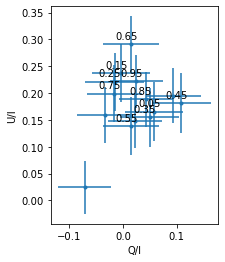

In [35]:
#plt.figure(figsize=(6,4))
plt.gca().set_aspect('equal')
plt.errorbar(np.tanh(ppp_phasequ.x[::2]),np.tanh(ppp_phasequ.x[1::2]),yerr=np.diag(ppp_phasequ.hess_inv)[1::2]**0.5/np.cosh(ppp_phasequ.x[1::2])**2,xerr=np.diag(ppp_phasequ.hess_inv)[::2]**0.5/np.cosh(ppp_phasequ.x[::2])**2,fmt='.')
for _xx,_yy,_tt in zip(np.tanh(ppp_phasequ.x[::2]),np.tanh(ppp_phasequ.x[1::2]),np.linspace(0.05,0.95,10)):
    plt.text(_xx-3e-2,_yy+1e-2,'%.2f' % _tt)
plt.xlabel('Q/I')
plt.ylabel('U/I')

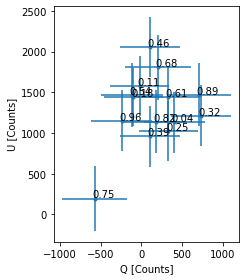

In [36]:
#plt.figure(figsize=(7,4))
plt.gca().set_aspect('equal')
plt.errorbar(np.tanh(ppp_phasequ.x[::2])*tt,np.tanh(ppp_phasequ.x[1::2])*tt,yerr=tt*np.diag(ppp_phasequ.hess_inv)[1::2]**0.5/np.cosh(ppp_phasequ.x[1::2])**2,xerr=tt*np.diag(ppp_phasequ.hess_inv)[::2]**0.5/np.cosh(ppp_phasequ.x[::2])**2,fmt='.')
for _xx,_yy,_tt,_qq in zip(np.tanh(ppp_phasequ.x[::2])*tt,np.tanh(ppp_phasequ.x[1::2])*tt,phlist,tt):
    plt.text(_xx-3e+1,_yy+1e+1,'%.2f' % (_tt))
param=ppp_rot2.x
ang=angfunk(param[1],param[2],phlist-param[4])+np.radians(param[3])
polfrac=np.tanh(param[0])
if (len(param)>5):
    polfrac*=(1+param[5]*np.cos(2*np.pi*(phlist-param[6])))

qloc=np.cos(2*ang)*polfrac*60000
uloc=np.sin(2*ang)*polfrac*60000
#plt.plot(qloc,uloc)  
#plt.xlim(-18000,5000)
#plt.ylim(0,12000)
#plt.ylim(-0.1,0.3)
plt.xlabel('Q [Counts]')
plt.ylabel('U [Counts]')
plt.tight_layout()
plt.savefig('figures/QU.pdf')

# Plots

In [37]:
def plottwo(x,y,yerr=None,fmt=None,ax=None,**kwargs):
    _x=np.concatenate((x,x+1))
    _y=np.concatenate((y,y))
    if fmt is None:
        fmt='.'
    if ax is None:
        if yerr is None:
            plt.plot(_x,_y,xerr=(_x[1]-_x[0])/2,fmt=fmt,**kwargs)
        else:
            _yerr=np.concatenate((yerr,yerr))
            plt.errorbar(_x,_y,xerr=(_x[1]-_x[0])/2,yerr=_yerr,fmt=fmt,**kwargs)
    else:
        if yerr is None:
            ax.plot(_x,_y,xerr=(_x[1]-_x[0])/2,fmt=fmt,**kwargs)
        else:
            _yerr=np.concatenate((yerr,yerr))
            ax.errorbar(_x,_y,xerr=(_x[1]-_x[0])/2,yerr=_yerr,fmt=fmt,**kwargs)



In [38]:
def cfunk(p,a,b,c):
    return(a*np.cos((p-b)*2*np.pi)+c)

cfit=curve_fit(cfunk,0.5*toton[1][:-1]+0.5*toton[1][1:],toton[0],sigma=(toton[0])**0.5)
pfit=curve_fit(cfunk,(np.arange(len(ppp_phase.x)//2)+0.5)/10,100*np.abs(np.tanh(ppp_phase.x[1::2])),sigma=100*ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2])**2)

0.17224409448818898


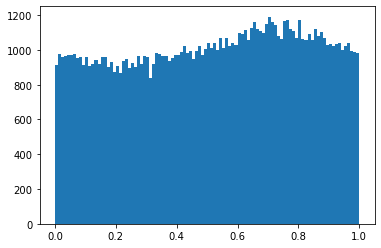

In [39]:
toton=plt.hist(phdata,bins=100)
print((toton[0].max()-toton[0].min())/(toton[0].max()+toton[0].min()))

0.17224409448818898 0.09936256856909398


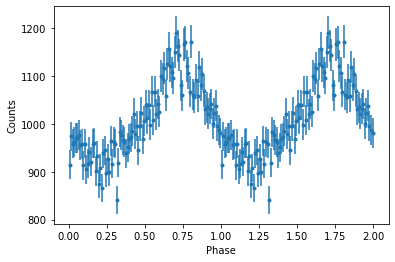

In [40]:

_ph=np.linspace(0,2,201)
plottwo(0.5*toton[1][:-1]+0.5*toton[1][1:],toton[0],(toton[0])**0.5,'.')
#plt.plot(_ph,cfunk(_ph,*cfit[0]))
plt.ylabel('Counts')
plt.xlabel('Phase')
print((toton[0].max()-toton[0].min())/(toton[0].max()+toton[0].min()),cfit[0][0]/cfit[0][2])
plt.savefig('figures/intensity.pdf')

0.18974280073453897 0.01984829760652058


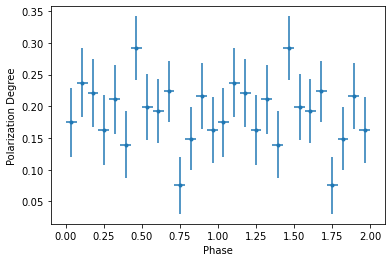

In [41]:
plottwo((np.arange(len(ppp_phase.x)//2)+0.5)/(len(ppp_phase.x)//2),np.abs(np.tanh(ppp_phase.x[1::2])),ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2])**2,'.')
#plt.plot(_ph,cfunk(_ph,*pfit[0])/100)
#plt.plot(_ph,np.abs(ppp_rot2.x[0]*(1+ppp_rot2.x[5]*np.cos(2*np.pi*(_ph-ppp_rot2.x[6])))))
plt.ylabel('Polarization Degree')
plt.xlabel('Phase')
plt.savefig('figures/polar-deg.pdf')
print(np.mean(np.abs(np.tanh(ppp_phase.x[1::2]))),np.sum((ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2]))**2)**0.5/10)


Alpha:                      91.3009
Beta:                       -89.1547
Mean Polarization Fraction: 0.189808
Ampl Polarization Fraction: 0.0262022
Peak Polarization Fraction: 0.827164
Pole across Line of Sight:  0.77357
Peak Flux:                  0.72353


Alpha:                      91.269
Beta:                       -89.2097
Mean Polarization Fraction: 0.188691
Pole across Line of Sight:  0.773417
Peak Flux:                  0.72353



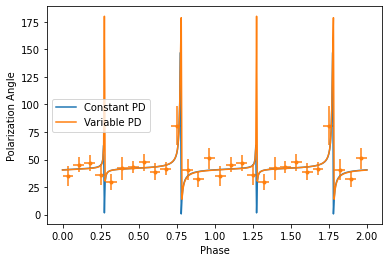

In [42]:
shift=0


plottwo((np.arange(len(ppp_phase.x)//2)+0.5)/(len(ppp_phase.x)//2),np.mod(np.degrees(np.where(ppp_phase.x[1::2]>0,0,np.pi*0.5)+ppp_phase.x[::2])-shift,180)+shift,np.degrees(ppp_phase_err[::2]),c='tab:orange')
_ph=np.linspace(0,2,401)
print('''
Alpha:                      %g
Beta:                       %g
Mean Polarization Fraction: %g
Ampl Polarization Fraction: %g
Peak Polarization Fraction: %g
Pole across Line of Sight:  %g
Peak Flux:                  %g
''' % ((ppp_rot2.x[1]%180,ppp_rot2.x[2])+tuple(np.mod(np.array([np.abs(np.tanh(ppp_rot2.x[0])),np.abs(ppp_rot2.x[5]*np.tanh(ppp_rot2.x[0])),
                                                            ppp_rot2.x[6],
                                                            ppp_rot2.x[4]+(0 if ppp_rot2.x[2]>0 else 0.5),
                                                            (cfit[0][1] if cfit[0][0]>0 else cfit[0][1]-0.5)]),1))))
print('''
Alpha:                      %g
Beta:                       %g
Mean Polarization Fraction: %g
Pole across Line of Sight:  %g
Peak Flux:                  %g
''' % (ppp_rot.x[1]%180,ppp_rot.x[2],np.abs(np.tanh(ppp_rot.x[0])),np.mod(ppp_rot.x[4]+(0 if ppp_rot.x[2]>0 else 0.5),1),
                                                            np.mod(cfit[0][1] if cfit[0][0]>0 else cfit[0][1]-0.5,1)))
if ppp_rot.x[0]>0:
    plt.plot(_ph,np.degrees(np.mod((angfunk(ppp_rot.x[1],ppp_rot.x[2],_ph-ppp_rot.x[4])+np.radians(ppp_rot.x[3]-shift)),np.pi))+shift,label='Constant PD')
else:
    plt.plot(_ph,np.degrees(np.mod(np.pi/2+(angfunk(ppp_rot.x[1],ppp_rot.x[2],_ph-ppp_rot.x[4])+np.radians(ppp_rot.x[3]-shift)),np.pi))+shift,label='Constant PD')

if ppp_rot2.x[0]>0:
    plt.plot(_ph,np.degrees(np.mod((angfunk(ppp_rot2.x[1],ppp_rot2.x[2],_ph-ppp_rot2.x[4])+np.radians(ppp_rot2.x[3]-shift)),np.pi))+shift,label='Variable PD')
else:
    plt.plot(_ph,np.degrees(np.mod(np.pi/2+(angfunk(ppp_rot2.x[1],ppp_rot2.x[2],_ph-ppp_rot2.x[4])+np.radians(ppp_rot2.x[3]-shift)),np.pi))+shift,label='Variable PD')

#plt.plot(_ph,np.degrees(np.mod((angfunk(medvalues1[1],medvalues1[2],_ph-medvalues1[4])+np.radians(medvalues1[3]-shift)),np.pi))+shift,c='tab:blue',label='MCMC1')
#plt.plot(_ph,np.degrees(np.mod((angfunk(medvalues2[1],medvalues2[2],_ph-medvalues2[4])+np.radians(medvalues2[3]-shift)),np.pi))+shift,c='tab:orange',label='MCMC2')

#plt.plot(_ph,np.degrees(np.mod((angfunk(60.8,16.8,_ph-0.272)+np.radians(45.2-shift)),np.pi))+shift,label='MCMC')
    
#plt.ylim(25,75)
plt.ylabel('Polarization Angle')
plt.xlabel('Phase')
plt.legend()
plt.savefig('figures/polar-angle.pdf')

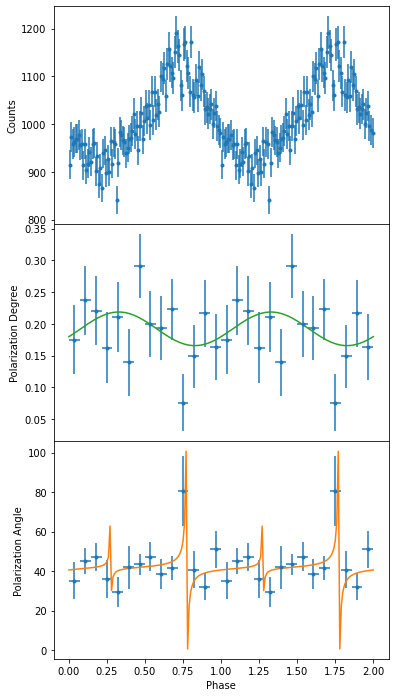

In [43]:
shift=0

fig, (ax1, ax2, ax3) = plt.subplots(3, 1,sharex=True,figsize=(6,12))
_ph=np.linspace(0,2,201)
plottwo(0.5*toton[1][:-1]+0.5*toton[1][1:],toton[0],(toton[0])**0.5,'.',ax1)
ax1.set_ylabel('Counts')
plottwo((np.arange(len(ppp_phase.x)//2)+0.5)/(len(ppp_phase.x)//2),np.abs(np.tanh(ppp_phase.x[1::2])),ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2])**2,'.',ax2)
ax2.plot(_ph,np.abs(ppp_rot2.x[0]*(1+ppp_rot2.x[5]*np.cos(2*np.pi*(_ph-ppp_rot2.x[6])))),c='tab:green')
ax2.set_ylabel('Polarization Degree')
plottwo((np.arange(len(ppp_phase.x)//2)+0.5)/(len(ppp_phase.x)//2),np.mod(np.degrees(np.where(ppp_phase.x[1::2]>0,0,np.pi*0.5)+ppp_phase.x[::2])-shift,180)+shift,np.degrees(ppp_phase_err[::2]),'.',ax3)
ax3.plot(_ph,np.degrees(np.mod((angfunk(ppp_rot.x[1],ppp_rot.x[2],_ph-ppp_rot.x[4])+np.radians(ppp_rot.x[3]-shift)),np.pi))+shift)


ax3.set_ylabel('Polarization Angle')
plt.xlabel('Phase')
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('figures/triple.pdf')

# Energy Dependence

In [44]:
pibin=np.clip(((evtlist['PI']-50)//25).astype(int),0,4)
def maxlikeenergy(param):
    return(-np.sum(np.log(1+0.5*(np.tanh(param[2*pibin])*qrot+np.tanh(param[2*pibin+1])*urot))))
def maxlikeenergy2(param):
    return(-np.sum(np.log(1+0.5*(np.tanh(param[pibin])*qrot))))


In [45]:
angdata=angfunk( ppp_rot.x[1],  ppp_rot.x[2], phdata-ppp_rot.x[4])+np.radians(ppp_rot.x[3])

sangdata=np.sin(2*angdata)
cangdata=np.cos(2*angdata)
urot=evtlist['U']*cangdata-evtlist['Q']*sangdata
qrot=evtlist['U']*sangdata+evtlist['Q']*cangdata
um,qm=np.mean(urot/moddata),np.mean(qrot/moddata)
print(um,qm,np.hypot(um,qm),np.std(qrot/moddata)/len(qrot)**0.5,np.std(qrot)/np.mean(moddata)/len(qrot)**0.5)
urot*=moddata
qrot*=moddata

0.006828779871097176 0.16359460073457482 0.16373706246306258 0.017526215713096645 0.014569882833672118


In [46]:
ppp_spec_deg=minimize(maxlikeenergy2,np.random.uniform(size=5)-0.5)

In [47]:
ppp_spec_qu=minimize(maxlikeenergy,np.random.uniform(size=10)-0.5)

Text(0, 0.5, 'U/I')

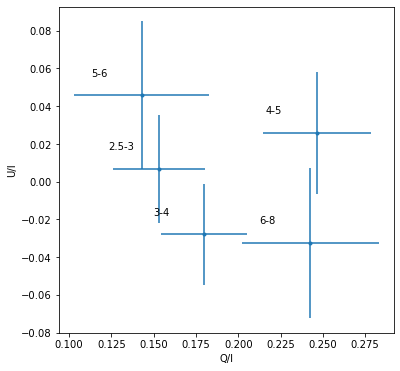

In [48]:
plt.figure(figsize=(6,6))
plt.errorbar(np.tanh(ppp_spec_qu.x[::2]),np.tanh(ppp_spec_qu.x[1::2]),yerr=np.diag(ppp_spec_qu.hess_inv)[1::2]**0.5/np.cosh(ppp_spec_qu.x[1::2])**2,xerr=np.diag(ppp_spec_qu.hess_inv)[::2]**0.5/np.cosh(ppp_spec_qu.x[::2])**2,fmt='.')
for _xx,_yy,_tt in zip(np.tanh(ppp_spec_qu.x[::2]),np.tanh(ppp_spec_qu.x[1::2]),['2.5-3','3-4','4-5','5-6','6-8']):
    plt.text(_xx-3e-2,_yy+1e-2,_tt)
#plt.xlim(-0.29,0.29)
#plt.ylim(-0.29,0.29)
plt.xlabel('Q/I')
plt.ylabel('U/I')

Text(0, 0.5, 'Q/I')

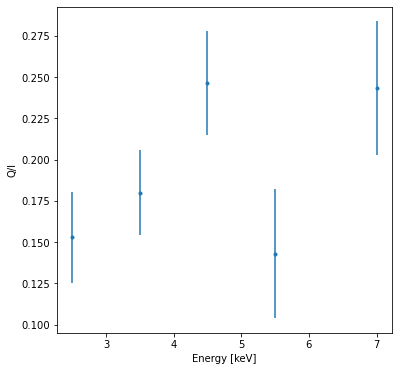

In [49]:
plt.figure(figsize=(6,6))
_xxx=[2.5,3.5,4.5,5.5,7]
plt.errorbar(_xxx,np.tanh(ppp_spec_deg.x),yerr=np.diag(ppp_spec_deg.hess_inv)**0.5/np.cosh(ppp_spec_deg.x)**2,fmt='.')
plt.xlabel('Energy [keV]')
plt.ylabel('Q/I')

# Bin optimization

In [50]:
_ii=np.argsort(evtlist['PI'])
pisort=evtlist['PI'][_ii]
modsort=moddata[_ii]

In [51]:
modcum=np.cumsum(modsort)
def mdpfunk(imin,imax):
    return(4.29/((modcum[imax]-modcum[imin])/(imax-imin))/(imax-imin)**0.5)
def mdppi(pimin,pimax):
    _imin=np.interp(pimin,pisort,range(len(pisort))).astype(int)
    _imax=np.interp(pimax,pisort,range(len(pisort))).astype(int)

    return mdpfunk(_imin,_imax)

In [52]:
modscum=np.cumsum(modsort**2)

In [53]:
plist=np.interp(np.linspace(0,1,70),modscum/modscum[-1],np.arange(len(modcum))).astype(int)
plist

array([     0,   7031,  12338,  16731,  20504,  23846,  26866,  29635,
        32172,  34546,  36782,  38893,  40901,  42816,  44649,  46410,
        48104,  49738,  51318,  52849,  54336,  55782,  57190,  58563,
        59904,  61217,  62503,  63764,  65002,  66215,  67406,  68576,
        69726,  70858,  71969,  73064,  74143,  75205,  76253,  77285,
        78304,  79309,  80299,  81274,  82236,  83184,  84117,  85035,
        85940,  86829,  87701,  88559,  89401,  90227,  91036,  91829,
        92605,  93362,  94102,  94824,  95528,  96213,  96882,  97535,
        98173,  98796,  99405, 100000, 100581, 101150])

In [54]:
for ii in range(len(plist)-1):
    _imin=plist[ii]
    _imax=plist[ii+1]
    _pmin,_pmax=pisort[_imin],pisort[_imax]
    # print(ii,_pmin,_pmax,_pmin/25,_pmax/25,mdpfunk(plist[ii],plist[ii+1]))

In [55]:
pilist=np.concatenate((pisort[plist[0:65:5]],pisort[plist[65:]]))
elist=pilist/25

In [56]:
pibin=np.digitize(evtlist['PI'],pilist)-1
pibin.min(),pibin.max()

(0, 17)

In [57]:
ppp_spec_deg=minimize(maxlikeenergy2,np.random.uniform(size=pibin.max()+1)-0.5)

In [58]:
ppp_spec_qu=minimize(maxlikeenergy,np.random.uniform(size=2*pibin.max()+2)-0.5)

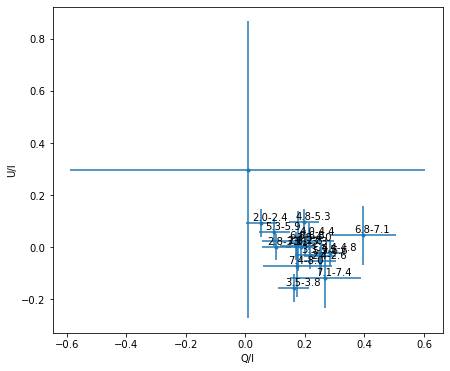

In [59]:
plt.figure(figsize=(7,6))
plt.errorbar(np.tanh(ppp_spec_qu.x[::2]),np.tanh(ppp_spec_qu.x[1::2]),yerr=np.diag(ppp_spec_qu.hess_inv)[1::2]**0.5/np.cosh(ppp_spec_qu.x[1::2])**2,xerr=np.diag(ppp_spec_qu.hess_inv)[::2]**0.5/np.cosh(ppp_spec_qu.x[::2])**2,fmt='.')
for _xx,_yy,_e0,_e1 in zip(np.tanh(ppp_spec_qu.x[::2]),np.tanh(ppp_spec_qu.x[1::2]),elist[:-1],elist[1:]):
    plt.text(_xx-3e-2,_yy+1e-2,'%.1f-%.1f' % (_e0,_e1))
#plt.xlim(-0.4,0.3)
#plt.ylim(-0.3,0.3)
plt.xlabel('Q/I')
plt.ylabel('U/I')
plt.savefig('figures/QU-energy_v1.pdf')

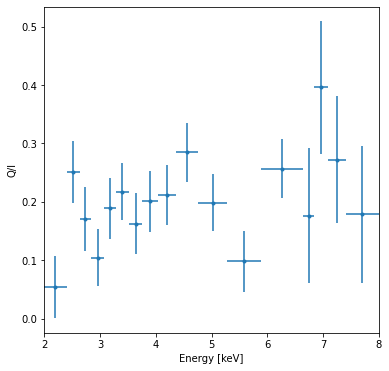

In [60]:
plt.figure(figsize=(6,6))

plt.errorbar(0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_deg.x)[:-1],
             yerr=(np.diag(ppp_spec_deg.hess_inv)**0.5/np.cosh(ppp_spec_deg.x)**2)[:-1],
             xerr=0.5*(-elist[:-1]+elist[1:]),fmt='.')
plt.xlim(2,8)

plt.xlabel('Energy [keV]')
plt.ylabel('Q/I')
plt.savefig('figures/polar-energy.pdf')
np.save('output/qoveri',[0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_deg.x)[:-1],
             (np.diag(ppp_spec_deg.hess_inv)**0.5/np.cosh(ppp_spec_deg.x)**2)[:-1],
             0.5*(-elist[:-1]+elist[1:])])

In [61]:
with open('output/poldeg_energy.dat','w') as f:
    print('#     Emid        Q/I       EQ/I   DeltaE/2')
    f.write('#     Emid        Q/I       EQ/I   DeltaE/2\n')

    for r in zip(0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_deg.x)[:-1],
                 (np.diag(ppp_spec_deg.hess_inv)**0.5/np.cosh(ppp_spec_deg.x)**2)[:-1],
                 0.5*(-elist[:-1]+elist[1:])):
        print(('%10g '*4) % r)
        f.write((('%10g '*4) % r)+'\n')

#     Emid        Q/I       EQ/I   DeltaE/2
       2.2  0.0536598  0.0526968        0.2 
      2.52   0.250553  0.0530875       0.12 
      2.74   0.171139  0.0548331        0.1 
      2.96   0.104285  0.0487023       0.12 
      3.18   0.188727  0.0528151        0.1 
       3.4   0.217139  0.0490308       0.12 
      3.64   0.162405  0.0525243       0.12 
       3.9   0.200603  0.0515501       0.14 
       4.2   0.212303  0.0514456       0.16 
      4.56   0.285082  0.0504359        0.2 
      5.02   0.198134  0.0490022       0.26 
      5.58  0.0979626  0.0523942        0.3 
      6.26    0.25617   0.050515       0.38 
      6.74   0.176449   0.115331        0.1 
      6.96   0.395736   0.113108       0.12 
      7.24   0.271829   0.108991       0.16 
       7.7   0.178328   0.117793        0.3 


In [62]:
with open('output/QU_energy.dat','w') as f:
    print('#    Emid         Q/I       EQ/I        U/I       EU/I   DeltaE/2')
    f.write('#    Emid         Q/I       EQ/I        U/I       EU/I   DeltaE/2\n')

    for r in zip(0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_qu.x[::2]),np.diag(ppp_spec_qu.hess_inv)[::2]**0.5/np.cosh(ppp_spec_qu.x[::2])**2,
                 np.tanh(ppp_spec_qu.x[1::2]),np.diag(ppp_spec_qu.hess_inv)[1::2]**0.5/np.cosh(ppp_spec_qu.x[1::2])**2,
                0.5*(-elist[:-1]+elist[1:])):
        print(('%10g '*6) % r)
        f.write((('%10g '*6) % r)+'\n')

#    Emid         Q/I       EQ/I        U/I       EU/I   DeltaE/2
       2.2  0.0533853  0.0526596  0.0934373  0.0530737        0.2 
      2.52   0.250541  0.0530271  -0.053736  0.0531861       0.12 
      2.74   0.171203  0.0542541 0.00524768  0.0541075        0.1 
      2.96   0.104276  0.0487424 0.00102351  0.0492967       0.12 
      3.18   0.188726  0.0531147 -0.00019969  0.0534038        0.1 
       3.4   0.217151  0.0489486 -0.0314987  0.0500351       0.12 
      3.64   0.162816  0.0519729  -0.157472  0.0535735       0.12 
       3.9   0.200651    0.05037  0.0159773  0.0514314       0.14 
       4.2   0.212469  0.0511689  0.0401732  0.0517592       0.16 
      4.56   0.285091  0.0499088  -0.021241  0.0509978        0.2 
      5.02   0.198281  0.0500539  0.0965187  0.0489047       0.26 
      5.58  0.0976074  0.0530722  0.0571634  0.0517197        0.3 
      6.26   0.255811  0.0504826 -0.0345286  0.0513004       0.38 
      6.74   0.177918   0.121373  0.0237136   0.113837        

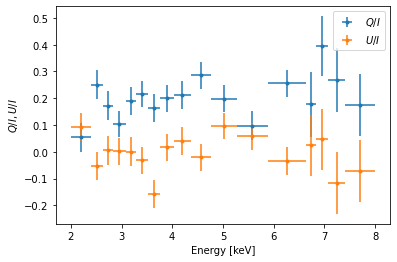

In [63]:
plt.errorbar(0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_qu.x)[:-2:2],
             yerr=(np.diag(ppp_spec_qu.hess_inv)**0.5/np.cosh(ppp_spec_qu.x)**2)[:-2:2],
             xerr=0.5*(-elist[:-1]+elist[1:]),fmt='.',label=r'$Q/I$')
plt.errorbar(0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_qu.x)[1:-1:2],
             yerr=(np.diag(ppp_spec_qu.hess_inv)**0.5/np.cosh(ppp_spec_qu.x)**2)[1:-1:2],
             xerr=0.5*(-elist[:-1]+elist[1:]),fmt='.',label=r'$U/I$')
plt.legend()
plt.xlabel('Energy [keV]')
plt.ylabel(r'$Q/I, U/I$')
plt.savefig('figures/QU-energy_v2.pdf')

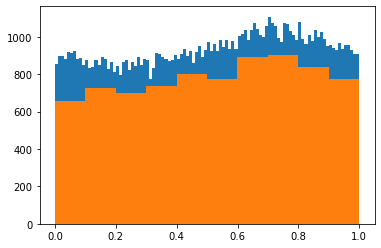

In [64]:
oklow=evtlist['PI']<=5.5*25
totonl=plt.hist(phdata[oklow],bins=100)
totonh=plt.hist(phdata[~oklow],bins=10)

Text(0.5, 0, 'Phase')

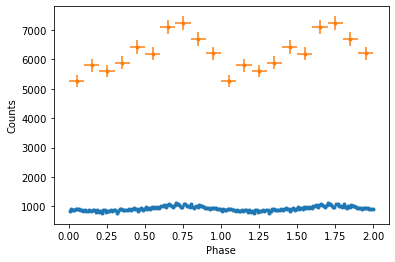

In [65]:
_ph=np.linspace(0,2,201)
plottwo(0.5*totonl[1][:-1]+0.5*totonl[1][1:],totonl[0],(totonl[0])**0.5,'.')
_ph=np.linspace(0,2,21)
plottwo(0.5*totonh[1][:-1]+0.5*totonh[1][1:],8*totonh[0],8*(totonh[0])**0.5,'.')

#plt.plot(_ph,cfunk(_ph,*cfit[0]))
plt.ylabel('Counts')
plt.xlabel('Phase')

In [66]:
ppp_rot_low=minimize(maxlikerotation2_ok,ppp_rot2.x,method='Nelder-Mead',args=(phdata[oklow],qdata[oklow],udata[oklow]))
ppp_rot_high=minimize(maxlikerotation2_ok,ppp_rot2.x,method='Nelder-Mead',args=(phdata[~oklow],qdata[~oklow],udata[~oklow]))

In [67]:
np.save("output/totonh.npy",totonh)
np.save("output/totonl.npy",totonl)
np.save('output/ppp_rot',(ppp_rot2,ppp_rot_low,ppp_rot_high))

/home/idies/miniconda3/envs/heasoft/lib/python3.8/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


0.18974280073453897 0.01984829760652058


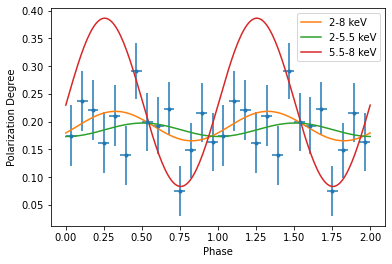

In [68]:
_ph=np.linspace(0,2,201)
plottwo((np.arange(len(ppp_phase.x)//2)+0.5)/(len(ppp_phase.x)//2),np.abs(np.tanh(ppp_phase.x[1::2])),ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2])**2,'.')
#plt.plot(_ph,cfunk(_ph,*pfit[0])/100)
plt.plot(_ph,np.abs(ppp_rot2.x[0]*(1+ppp_rot2.x[5]*np.cos(2*np.pi*(_ph-ppp_rot2.x[6])))),label='2-8 keV')
plt.plot(_ph,np.abs(ppp_rot_low.x[0]*(1+ppp_rot_low.x[5]*np.cos(2*np.pi*(_ph-ppp_rot_low.x[6])))),label='2-5.5 keV')
plt.plot(_ph,np.abs(ppp_rot_high.x[0]*(1+ppp_rot_high.x[5]*np.cos(2*np.pi*(_ph-ppp_rot_high.x[6])))),label='5.5-8 keV')
plt.ylabel('Polarization Degree')
plt.xlabel('Phase')
#plt.ylim(0.1,0.6)
plt.legend()
plt.savefig('figures/polar-deg-energy.pdf')
print(np.mean(np.abs(np.tanh(ppp_phase.x[1::2]))),np.sum((ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2]))**2)**0.5/10)


Alpha:                      91.269
Beta:                       -89.2097
Mean Polarization Fraction: 0.188691
Pole across Line of Sight:  0.773417
Peak Flux:                  0.72353



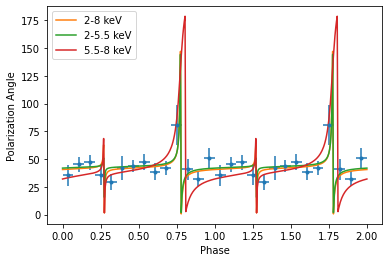

In [69]:
shift=0
plottwo((np.arange(len(ppp_phase.x)//2)+0.5)/(len(ppp_phase.x)//2),np.mod(np.degrees(np.where(ppp_phase.x[1::2]>0,0,np.pi*0.5)+ppp_phase.x[::2])-shift,180)+shift,np.degrees(ppp_phase_err[::2]),'.')
_ph=np.linspace(0,2,401)
print('''
Alpha:                      %g
Beta:                       %g
Mean Polarization Fraction: %g
Pole across Line of Sight:  %g
Peak Flux:                  %g
''' % (ppp_rot.x[1]%180,ppp_rot.x[2],np.abs(np.tanh(ppp_rot.x[0])),np.mod(ppp_rot.x[4]+(0 if ppp_rot.x[2]>0 else 0.5),1),
                                                            np.mod(cfit[0][1] if cfit[0][0]>0 else cfit[0][1]-0.5,1)))

if ppp_rot.x[0]>0:
    plt.plot(_ph,np.degrees(np.mod((angfunk(ppp_rot.x[1],ppp_rot.x[2],_ph-ppp_rot.x[4])+np.radians(ppp_rot.x[3]-shift)),np.pi))+shift,label='2-8 keV')
    plt.plot(_ph,np.degrees(np.mod((angfunk(ppp_rot_low.x[1],ppp_rot_low.x[2],_ph-ppp_rot_low.x[4])+np.radians(ppp_rot_low.x[3]-shift)),np.pi))+shift,label='2-5.5 keV')
    plt.plot(_ph,np.degrees(np.mod((angfunk(ppp_rot_high.x[1],ppp_rot_high.x[2],_ph-ppp_rot_high.x[4])+np.radians(ppp_rot_high.x[3]-shift)),np.pi))+shift,label='5.5-8 keV')
else:
    plt.plot(_ph,np.degrees(np.mod(np.pi/2+(angfunk(ppp_rot.x[1],ppp_rot.x[2],_ph-ppp_rot.x[4])+np.radians(ppp_rot.x[3]-shift)),np.pi))+shift)

'''if ppp_rot2.x[0]>0:
    plt.plot(_ph,np.degrees(np.mod((angfunk(ppp_rot2.x[1],ppp_rot2.x[2],_ph-ppp_rot2.x[4])+np.radians(ppp_rot2.x[3]-shift)),np.pi))+shift)
else:
    plt.plot(_ph,np.degrees(np.mod(np.pi/2+(angfunk(ppp_rot2.x[1],ppp_rot2.x[2],_ph-ppp_rot2.x[4])+np.radians(ppp_rot2.x[3]-shift)),np.pi))+shift)
    '''
#plt.ylim(25,75)
plt.ylabel('Polarization Angle')
plt.xlabel('Phase')
plt.legend()
plt.savefig('figures/polar-angle-energy.pdf')

In [70]:
from corner import corner
import numpy as np

In [71]:
ddd=np.loadtxt('minimum2M_RVM_v2.txt.gz')

FileNotFoundError: minimum2M_RVM_v2.txt.gz not found.

In [ ]:
c=corner(ddd[::100])

In [ ]:
dd4b=ddd
nskip=100
c=corner(dd4b[::nskip])

In [ ]:
dd4b=ddd
start=100000
nskip=100
c=corner(dd4b[start::nskip],weights=np.sin(np.radians(dd4b[start::nskip,1]))*np.sin(np.radians(dd4b[start::nskip,2])))

In [ ]:
ddd=np.loadtxt('minimum2M_RVM_v2prior.txt.gz')

In [ ]:
start=100000
dd4b=ddd
c=corner(dd4b[start::nskip])

In [ ]:
ddd=np.loadtxt('minimum2M_RVM_v2prior_2.txt.gz')

In [ ]:
start=1000000
dd4b=ddd
c=corner(dd4b[start::nskip])

In [ ]:
start=100000
fig=plt.figure(figsize=(10,10))
dd4b=1*ddd
dd4b[:,0]=np.tanh(dd4b[:,0])*100
dd4b[:,4]=np.where(dd4b[:,4]<0.45,dd4b[:,4]+1,dd4b[:,4])*100
c=corner(dd4b[start::nskip],labels=['Degree [%]',r'$i_p$',r'$\theta$',r'$\chi_p$',r'$\phi_0$ [%]'],quantiles=[0.16,0.5,0.84],show_titles=True,title_fmt='.1f',fig=fig)
fig.savefig('corner_epoch2.pdf')

In [ ]:
medvalues2=np.median(ddd[start::nskip],axis=0)

In [ ]:
ddd1=np.loadtxt('minimum-HerX1_1.txt.gz')

In [ ]:
start=100000
fig=plt.figure(figsize=(10,10))
dd4b=1*ddd1
dd4b[:,0]=np.tanh(dd4b[:,0])*100
dd4b[:,4]*=100
c=corner(dd4b[start::nskip],labels=['Degree [%]',r'$i_p$',r'$\theta$',r'$\chi_p$',r'$\phi_0$ [%]'],quantiles=[0.16,0.5,0.84],show_titles=True,title_fmt='.1f',fig=fig)
fig.savefig('corner_epoch1.pdf')

In [ ]:
medvalues1=np.median(ddd1[start::nskip],axis=0)

In [ ]:
medvalues2

In [ ]:
medvalues1

In [ ]:
MJDSTART,MJDSTART+deltat.max()/day